In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, ShuffleSplit

# Data Loading Tools

Steps 1 and 2

Lulu: make_time_windows and make_x_y is similar to Aisha's data_label_split and data_divide. Differences:
* make_x_y requires a single column to be selected and builds y's from it
* make_time_windows fixes the sequence length and drags the window down each participant's timeseries (not the concatenated npy with all visits)

To do:
* Normalisation/Scaling

In [2]:
def load_DoppelGANger():
  ori_data = np.load('ori_features_prism.npy')
  gen_data = np.load('features_600.npy')
  return ori_data, gen_data # both have np.shape = (1347 participants, 130 visits, 5 features)


def make_time_windows(dataset, w):
  """replaces each participant's 130 long timeseries with all their w length window timeseries
  """
  num_participants, full_length, _ = np.shape(dataset)
  time_windows = []

  for i in list(range(num_participants)): # i = participant's position in dataset

    for j in list(range(full_length-w+1)): # j = row number of first row in window
      time_windows.append(dataset[i,j:j+w,:])

  return np.stack(time_windows)


def make_x_y(dataset, y_index, w):
  """make inputs for model. Note input sequence length = w-1
  """
  dataset = make_time_windows(dataset, w)
  x = np.delete(dataset, obj=y_index, axis=2) # remove y column from all time series
  x = np.delete(x, obj=-1, axis=1) # remove last row from all time series
  y = dataset[:,1:,[y_index]] # take only y column and remove its earliest cell
  return x, y

Shape Checks:

In [3]:
ori_set, gen_set = load_DoppelGANger()
print([np.shape(_set) for _set in [ori_set, gen_set]])

x, y = make_x_y(ori_set, 0, 129)
print([np.shape(_set) for _set in [x, y]])
print([type(_set) for _set in [x, y]])

[(1347, 130, 5), (1347, 130, 5)]
[(2694, 128, 4), (2694, 128, 1)]
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>]


# Define Predictive Model

Lulu: moved import statements out of functions and to the top of the document

In [4]:
def last_time_step_mae(Y_true, Y_pred):
  return tf.keras.metrics.MAE(Y_true[:, -1], Y_pred[:, -1])

def make_predictive_model(num_cols):
  input_size = [None,num_cols-1] #
  hidden_dim = num_cols//2 #

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=input_size)) # shape = [#timesteps -1, #features=dim-1] per 
  model.add(tf.keras.layers.GRU(hidden_dim, return_sequences=True)) # shape = [#timesteps -1, hidden_dim]
  model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hidden_dim, activation = "sigmoid")))  # shape = [#timesteps -1, hidden_dim]
  model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation = "linear")))  # output shape = [#timesteps -1, 1]

  model.compile(optimizer = "adam", loss = tf.keras.losses.MeanAbsoluteError(), metrics=[last_time_step_mae])

  return model

# Define Evaluation Scheme

Lulu to do: 
* change args to list//tuple//dict type for easier looping through sets of prameters
* is loss working right? seems proportional to window length. Must normalise beforehand?

In [9]:
def predictive_train_test(train_set, test_set, y_cols='all', windows='max', val_ratio=0.2, batch_size=64, epochs=15, show_training=True):
  """ does the T_T_ portion of the scheme

  Args:
    - train_set, test_set: ori_data, gen_data in order of T_T_ (labels NOT yet split off)
      Make sure train and test are disjoint!
      If doing TSTSvsTRTR then use this function twice
    - y_cols: list of columns to use as target
    - windows: list contains lengths of windows to be used in order of y columns
              NOTE length of input sequences is actually window_length - 1 because of make_x_y
    - val_ratio: validation set ratio split from train_set for use during training
    - batch_size
    - epochs

  Returns:
   - results:
   """



  results = []
  histories = []
  _, max_window, num_columns = np.shape(train_set)
  
  #### for convenience when not tuning parameters
  if y_cols=='all':
    y_cols = list(range(num_columns))

  if windows=='max':
    windows=[max_window]*len(y_cols)
  elif isinstance(windows, int):
      windows=[windows]*len(y_cols)

  for k in range(len(y_cols)): # step 5 (repeating steps 2-4 for each column)
    print('\nPredictive model running for column ', str(y_cols[k]), ' with window length ', str(windows[k]))
    train_x, train_y = make_x_y(train_set, y_cols[k], windows[k]) # step 2
    test_x, test_y = make_x_y(test_set, y_cols[k], windows[k])
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=val_ratio)

    model = make_predictive_model(num_columns)
    hist = model.fit(np.asarray(train_x), np.asarray(train_y), batch_size=batch_size, epochs=epochs, validation_data=(val_x, val_y)) # step 4
    print('Getting results for column ', str(y_cols[k]), ' with window length ', str(windows[k]))

    results.append([y_cols[k], windows[k], batch_size, epochs]+model.evaluate(test_x, test_y, batch_size=batch_size))
    histories.append(hist)

    if show_training:
      plt.plot(hist.history['loss'])
      plt.plot(hist.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train loss', 'val loss'], loc='upper right')
      plt.show()

  results_df = pd.DataFrame(results, columns=['y_col', 'window_length', 'batch_size', 'epochs', 'test_loss', 'test_metric'])

  return results_df, histories

# TRTS Example


Predictive model running for column  0  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.9981 - last_time_step_mae: 1.1067 - val_loss: 6.7781 - val_last_time_step_mae: 0.8934
Epoch 2/15
1112/1112 [==============================] - 6s 5ms/step - loss: 6.7610 - last_time_step_mae: 0.8995 - val_loss: 6.7355 - val_last_time_step_mae: 0.8869
Epoch 3/15
1112/1112 [==============================] - 6s 5ms/step - loss: 6.7185 - last_time_step_mae: 0.8928 - val_loss: 6.6924 - val_last_time_step_mae: 0.8796
Epoch 4/15
1112/1112 [==============================] - 6s 5ms/step - loss: 6.6745 - last_time_step_mae: 0.8857 - val_loss: 6.6479 - val_last_time_step_mae: 0.8730
Epoch 5/15
1112/1112 [==============================] - 6s 5ms/step - loss: 6.6305 - last_time_step_mae: 0.8786 - val_loss: 6.6061 - val_last_time_step_mae: 0.8666
Epoch 6/15
1112/1112 [==============================] - 6s 5ms/step - loss: 6.5894 - last_time_step_mae: 0.8723 - va

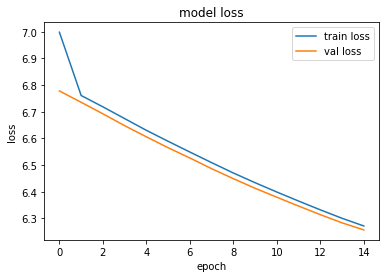


Predictive model running for column  1  with window length  65
Epoch 1/15
1112/1112 [==============================] - 6s 6ms/step - loss: 5.4683 - last_time_step_mae: 1.0110 - val_loss: 5.3048 - val_last_time_step_mae: 0.9043
Epoch 2/15
1112/1112 [==============================] - 6s 5ms/step - loss: 5.2071 - last_time_step_mae: 0.7949 - val_loss: 5.2518 - val_last_time_step_mae: 0.8961
Epoch 3/15
1112/1112 [==============================] - 6s 5ms/step - loss: 5.1574 - last_time_step_mae: 0.7871 - val_loss: 5.2032 - val_last_time_step_mae: 0.8869
Epoch 4/15
1112/1112 [==============================] - 6s 5ms/step - loss: 5.1129 - last_time_step_mae: 0.7802 - val_loss: 5.1586 - val_last_time_step_mae: 0.8792
Epoch 5/15
1112/1112 [==============================] - 6s 5ms/step - loss: 5.0689 - last_time_step_mae: 0.7732 - val_loss: 5.1137 - val_last_time_step_mae: 0.8711
Epoch 6/15
1112/1112 [==============================] - 6s 5ms/step - loss: 5.0262 - last_time_step_mae: 0.7663 - va

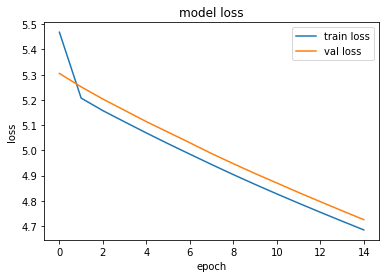


Predictive model running for column  2  with window length  65
Epoch 1/15
1112/1112 [==============================] - 6s 6ms/step - loss: 23.9680 - last_time_step_mae: 4.0763 - val_loss: 24.0143 - val_last_time_step_mae: 4.0011
Epoch 2/15
1112/1112 [==============================] - 6s 5ms/step - loss: 23.7209 - last_time_step_mae: 3.9886 - val_loss: 23.7585 - val_last_time_step_mae: 3.9607
Epoch 3/15
1112/1112 [==============================] - 6s 5ms/step - loss: 23.4204 - last_time_step_mae: 3.9399 - val_loss: 23.4052 - val_last_time_step_mae: 3.9047
Epoch 4/15
1112/1112 [==============================] - 6s 5ms/step - loss: 23.0276 - last_time_step_mae: 3.8748 - val_loss: 22.9803 - val_last_time_step_mae: 3.8373
Epoch 5/15
1112/1112 [==============================] - 6s 5ms/step - loss: 22.5963 - last_time_step_mae: 3.8043 - val_loss: 22.5429 - val_last_time_step_mae: 3.7680
Epoch 6/15
1112/1112 [==============================] - 6s 5ms/step - loss: 22.1637 - last_time_step_mae: 

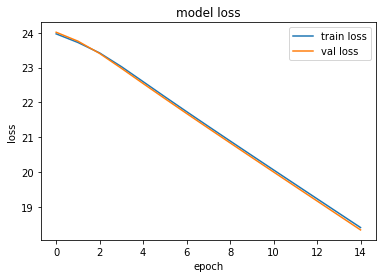


Predictive model running for column  3  with window length  65
Epoch 1/15
1112/1112 [==============================] - 6s 5ms/step - loss: 2.7865 - last_time_step_mae: 0.5434 - val_loss: 2.5559 - val_last_time_step_mae: 0.3468
Epoch 2/15
1112/1112 [==============================] - 6s 5ms/step - loss: 2.5336 - last_time_step_mae: 0.3603 - val_loss: 2.4926 - val_last_time_step_mae: 0.3363
Epoch 3/15
1112/1112 [==============================] - 6s 5ms/step - loss: 2.4835 - last_time_step_mae: 0.3523 - val_loss: 2.4515 - val_last_time_step_mae: 0.3300
Epoch 4/15
1112/1112 [==============================] - 6s 6ms/step - loss: 2.4451 - last_time_step_mae: 0.3461 - val_loss: 2.4152 - val_last_time_step_mae: 0.3239
Epoch 5/15
1112/1112 [==============================] - 6s 6ms/step - loss: 2.4092 - last_time_step_mae: 0.3402 - val_loss: 2.3801 - val_last_time_step_mae: 0.3181
Epoch 6/15
1112/1112 [==============================] - 6s 5ms/step - loss: 2.3740 - last_time_step_mae: 0.3344 - va

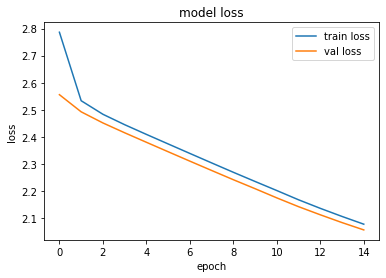


Predictive model running for column  4  with window length  65
Epoch 1/15
1112/1112 [==============================] - 6s 6ms/step - loss: 7.2046 - last_time_step_mae: 1.2058 - val_loss: 6.9821 - val_last_time_step_mae: 1.1388
Epoch 2/15
1112/1112 [==============================] - 6s 5ms/step - loss: 7.0537 - last_time_step_mae: 1.1723 - val_loss: 6.8454 - val_last_time_step_mae: 1.1173
Epoch 3/15
1112/1112 [==============================] - 6s 5ms/step - loss: 6.9123 - last_time_step_mae: 1.1493 - val_loss: 6.7018 - val_last_time_step_mae: 1.0937
Epoch 4/15
1112/1112 [==============================] - 6s 5ms/step - loss: 6.7574 - last_time_step_mae: 1.1239 - val_loss: 6.5408 - val_last_time_step_mae: 1.0679
Epoch 5/15
1112/1112 [==============================] - 6s 5ms/step - loss: 6.5816 - last_time_step_mae: 1.0952 - val_loss: 6.3570 - val_last_time_step_mae: 1.0388
Epoch 6/15
1112/1112 [==============================] - 6s 5ms/step - loss: 6.3812 - last_time_step_mae: 1.0621 - va

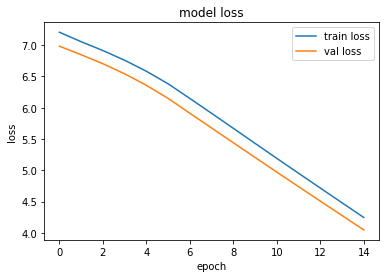

In [10]:
TRTS_results, TRTS_histories = predictive_train_test(ori_set, gen_set, windows=[65,65,65,65,65])

In [11]:
TRTS_results

,y_col,window_length,batch_size,epochs,test_loss,test_metric
0,0,65,64,15,7.622626,1.224790
1,1,65,64,15,5.797283,0.755767
2,2,65,64,15,18.063339,2.549275
3,3,65,64,15,1.696070,0.207226
4,4,65,64,15,3.968819,0.597097


# TSTR Example


Predictive model running for column  0  with window length  20
Epoch 1/20
1869/1869 [==============================] - 8s 4ms/step - loss: 10.0570 - last_time_step_mae: 6.6730 - val_loss: 9.8590 - val_last_time_step_mae: 6.4643
Epoch 2/20
1869/1869 [==============================] - 7s 4ms/step - loss: 9.9650 - last_time_step_mae: 6.6111 - val_loss: 9.7516 - val_last_time_step_mae: 6.3947
Epoch 3/20
1869/1869 [==============================] - 7s 4ms/step - loss: 9.8309 - last_time_step_mae: 6.5239 - val_loss: 9.5860 - val_last_time_step_mae: 6.2889
Epoch 4/20
1869/1869 [==============================] - 7s 4ms/step - loss: 9.6441 - last_time_step_mae: 6.4043 - val_loss: 9.3796 - val_last_time_step_mae: 6.1595
Epoch 5/20
1869/1869 [==============================] - 7s 4ms/step - loss: 9.4353 - last_time_step_mae: 6.2704 - val_loss: 9.1685 - val_last_time_step_mae: 6.0278
Epoch 6/20
1869/1869 [==============================] - 7s 4ms/step - loss: 9.2312 - last_time_step_mae: 6.1409 - v

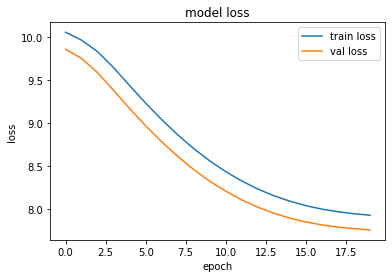


Predictive model running for column  1  with window length  20
Epoch 1/20
1869/1869 [==============================] - 8s 4ms/step - loss: 7.6477 - last_time_step_mae: 5.3997 - val_loss: 7.4210 - val_last_time_step_mae: 5.3289
Epoch 2/20
1869/1869 [==============================] - 7s 4ms/step - loss: 7.1888 - last_time_step_mae: 5.0784 - val_loss: 6.9306 - val_last_time_step_mae: 4.9839
Epoch 3/20
1869/1869 [==============================] - 7s 4ms/step - loss: 6.7119 - last_time_step_mae: 4.7462 - val_loss: 6.4788 - val_last_time_step_mae: 4.6640
Epoch 4/20
1869/1869 [==============================] - 7s 4ms/step - loss: 6.3074 - last_time_step_mae: 4.4613 - val_loss: 6.1065 - val_last_time_step_mae: 4.3976
Epoch 5/20
1869/1869 [==============================] - 7s 4ms/step - loss: 5.9627 - last_time_step_mae: 4.2171 - val_loss: 5.7833 - val_last_time_step_mae: 4.1634
Epoch 6/20
1869/1869 [==============================] - 7s 4ms/step - loss: 5.6647 - last_time_step_mae: 4.0058 - va

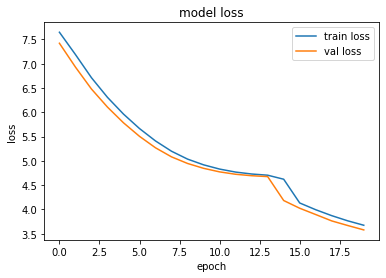


Predictive model running for column  2  with window length  20
Epoch 1/20
1869/1869 [==============================] - 8s 4ms/step - loss: 28.1110 - last_time_step_mae: 20.0401 - val_loss: 27.9107 - val_last_time_step_mae: 20.1985
Epoch 2/20
1869/1869 [==============================] - 8s 4ms/step - loss: 27.6824 - last_time_step_mae: 19.7414 - val_loss: 27.4478 - val_last_time_step_mae: 19.8673
Epoch 3/20
1869/1869 [==============================] - 7s 4ms/step - loss: 27.2039 - last_time_step_mae: 19.4089 - val_loss: 26.9630 - val_last_time_step_mae: 19.5202
Epoch 4/20
1869/1869 [==============================] - 7s 4ms/step - loss: 26.7178 - last_time_step_mae: 19.0702 - val_loss: 26.4785 - val_last_time_step_mae: 19.1733
Epoch 5/20
1869/1869 [==============================] - 7s 4ms/step - loss: 26.2339 - last_time_step_mae: 18.7332 - val_loss: 25.9972 - val_last_time_step_mae: 18.8287
Epoch 6/20
1869/1869 [==============================] - 7s 4ms/step - loss: 25.7546 - last_time_

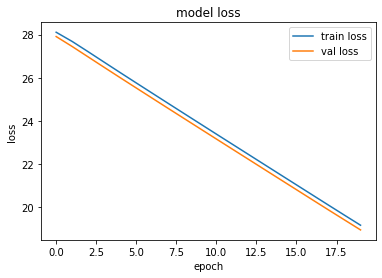


Predictive model running for column  3  with window length  20
Epoch 1/20
1869/1869 [==============================] - 8s 4ms/step - loss: 2.4843 - last_time_step_mae: 1.7468 - val_loss: 2.3316 - val_last_time_step_mae: 1.6275
Epoch 2/20
1869/1869 [==============================] - 7s 4ms/step - loss: 2.2383 - last_time_step_mae: 1.5721 - val_loss: 2.1080 - val_last_time_step_mae: 1.4688
Epoch 3/20
1869/1869 [==============================] - 7s 4ms/step - loss: 2.0541 - last_time_step_mae: 1.4418 - val_loss: 1.9402 - val_last_time_step_mae: 1.3501
Epoch 4/20
1869/1869 [==============================] - 7s 4ms/step - loss: 1.8940 - last_time_step_mae: 1.3292 - val_loss: 1.7830 - val_last_time_step_mae: 1.2382
Epoch 5/20
1869/1869 [==============================] - 7s 4ms/step - loss: 1.7474 - last_time_step_mae: 1.2284 - val_loss: 1.6653 - val_last_time_step_mae: 1.1615
Epoch 6/20
1869/1869 [==============================] - 7s 4ms/step - loss: 1.6507 - last_time_step_mae: 1.1605 - va

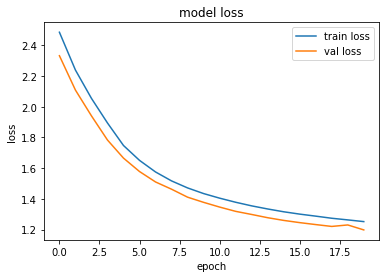


Predictive model running for column  4  with window length  20
Epoch 1/20
1869/1869 [==============================] - 8s 4ms/step - loss: 8.2234 - last_time_step_mae: 5.7914 - val_loss: 7.8038 - val_last_time_step_mae: 5.4947
Epoch 2/20
1869/1869 [==============================] - 8s 4ms/step - loss: 7.3288 - last_time_step_mae: 5.1494 - val_loss: 6.8620 - val_last_time_step_mae: 4.8364
Epoch 3/20
1869/1869 [==============================] - 7s 4ms/step - loss: 6.3961 - last_time_step_mae: 4.4955 - val_loss: 5.9608 - val_last_time_step_mae: 4.2055
Epoch 4/20
1869/1869 [==============================] - 7s 4ms/step - loss: 5.5430 - last_time_step_mae: 3.8987 - val_loss: 5.1269 - val_last_time_step_mae: 3.6214
Epoch 5/20
1869/1869 [==============================] - 7s 4ms/step - loss: 4.7149 - last_time_step_mae: 3.3191 - val_loss: 4.3019 - val_last_time_step_mae: 3.0434
Epoch 6/20
1869/1869 [==============================] - 7s 4ms/step - loss: 3.8915 - last_time_step_mae: 2.7432 - va

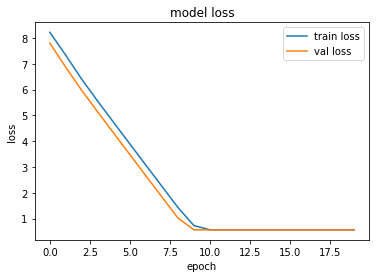

In [14]:
TSTR_results, TSTR_histories = predictive_train_test(gen_set, ori_set, windows=[20,20,20,20,20], epochs=20)

In [15]:
TSTR_results

,y_col,window_length,batch_size,epochs,test_loss,test_metric
0,0,20,64,20,5.973364,3.789750
1,1,20,64,20,2.383414,1.705138
2,2,20,64,20,19.515024,14.088824
3,3,20,64,20,1.591016,1.168527
4,4,20,64,20,0.433378,0.341097


# TRTR vs TSTS Example


Predictive model running for column  0  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 41ms/step - loss: 11.9734 - last_time_step_mae: 0.8670 - val_loss: 12.3613 - val_last_time_step_mae: 0.8508
Epoch 2/10
9/9 [==============================] - 0s 9ms/step - loss: 11.9473 - last_time_step_mae: 0.8392 - val_loss: 12.3352 - val_last_time_step_mae: 0.8228
Epoch 3/10
9/9 [==============================] - 0s 9ms/step - loss: 11.9210 - last_time_step_mae: 0.8112 - val_loss: 12.3088 - val_last_time_step_mae: 0.7945
Epoch 4/10
9/9 [==============================] - 0s 9ms/step - loss: 11.8944 - last_time_step_mae: 0.7826 - val_loss: 12.2820 - val_last_time_step_mae: 0.7656
Epoch 5/10
9/9 [==============================] - 0s 9ms/step - loss: 11.8674 - last_time_step_mae: 0.7534 - val_loss: 12.2548 - val_last_time_step_mae: 0.7360
Epoch 6/10
9/9 [==============================] - 0s 9ms/step - loss: 11.8400 - last_time_step_mae: 0.7235 - val_loss: 12.2270 - val_l

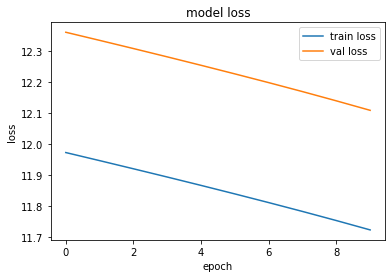


Predictive model running for column  1  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 42ms/step - loss: 7.5203 - last_time_step_mae: 0.0897 - val_loss: 6.9048 - val_last_time_step_mae: 0.0753
Epoch 2/10
9/9 [==============================] - 0s 9ms/step - loss: 7.4966 - last_time_step_mae: 0.0651 - val_loss: 6.8812 - val_last_time_step_mae: 0.0505
Epoch 3/10
9/9 [==============================] - 0s 9ms/step - loss: 7.4729 - last_time_step_mae: 0.0401 - val_loss: 6.8573 - val_last_time_step_mae: 0.0253
Epoch 4/10
9/9 [==============================] - 0s 8ms/step - loss: 7.4487 - last_time_step_mae: 0.0148 - val_loss: 6.8335 - val_last_time_step_mae: 3.8091e-04
Epoch 5/10
9/9 [==============================] - 0s 9ms/step - loss: 7.4377 - last_time_step_mae: 0.0067 - val_loss: 6.8380 - val_last_time_step_mae: 0.0108
Epoch 6/10
9/9 [==============================] - 0s 8ms/step - loss: 7.4385 - last_time_step_mae: 0.0093 - val_loss: 6.8347 - val_last_time

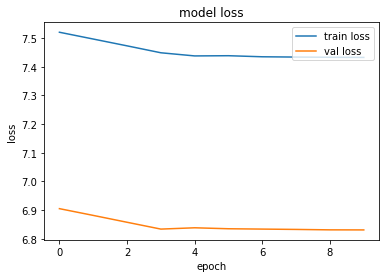


Predictive model running for column  2  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 41ms/step - loss: 32.8569 - last_time_step_mae: 1.1924 - val_loss: 32.9654 - val_last_time_step_mae: 1.1765
Epoch 2/10
9/9 [==============================] - 0s 8ms/step - loss: 32.8350 - last_time_step_mae: 1.1655 - val_loss: 32.9447 - val_last_time_step_mae: 1.1498
Epoch 3/10
9/9 [==============================] - 0s 8ms/step - loss: 32.8167 - last_time_step_mae: 1.1387 - val_loss: 32.9266 - val_last_time_step_mae: 1.1229
Epoch 4/10
9/9 [==============================] - 0s 8ms/step - loss: 32.7992 - last_time_step_mae: 1.1118 - val_loss: 32.9089 - val_last_time_step_mae: 1.0959
Epoch 5/10
9/9 [==============================] - 0s 9ms/step - loss: 32.7810 - last_time_step_mae: 1.0847 - val_loss: 32.8904 - val_last_time_step_mae: 1.0689
Epoch 6/10
9/9 [==============================] - 0s 9ms/step - loss: 32.7626 - last_time_step_mae: 1.0579 - val_loss: 32.8713 - val_l

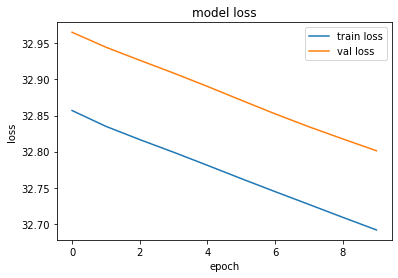


Predictive model running for column  3  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 43ms/step - loss: 3.6982 - last_time_step_mae: 0.1220 - val_loss: 3.3679 - val_last_time_step_mae: 0.1107
Epoch 2/10
9/9 [==============================] - 0s 8ms/step - loss: 3.6864 - last_time_step_mae: 0.1028 - val_loss: 3.3562 - val_last_time_step_mae: 0.0916
Epoch 3/10
9/9 [==============================] - 0s 9ms/step - loss: 3.6760 - last_time_step_mae: 0.0837 - val_loss: 3.3462 - val_last_time_step_mae: 0.0727
Epoch 4/10
9/9 [==============================] - 0s 9ms/step - loss: 3.6665 - last_time_step_mae: 0.0650 - val_loss: 3.3369 - val_last_time_step_mae: 0.0542
Epoch 5/10
9/9 [==============================] - 0s 8ms/step - loss: 3.6576 - last_time_step_mae: 0.0466 - val_loss: 3.3278 - val_last_time_step_mae: 0.0358
Epoch 6/10
9/9 [==============================] - 0s 10ms/step - loss: 3.6490 - last_time_step_mae: 0.0284 - val_loss: 3.3190 - val_last_time_st

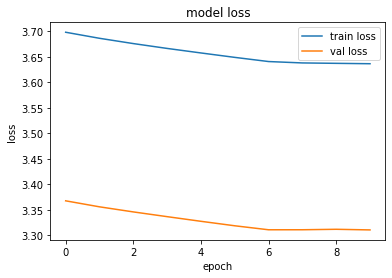


Predictive model running for column  4  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 41ms/step - loss: 10.1083 - last_time_step_mae: 0.4245 - val_loss: 10.5343 - val_last_time_step_mae: 0.4086
Epoch 2/10
9/9 [==============================] - 0s 8ms/step - loss: 10.0811 - last_time_step_mae: 0.3974 - val_loss: 10.5071 - val_last_time_step_mae: 0.3814
Epoch 3/10
9/9 [==============================] - 0s 9ms/step - loss: 10.0541 - last_time_step_mae: 0.3699 - val_loss: 10.4802 - val_last_time_step_mae: 0.3536
Epoch 4/10
9/9 [==============================] - 0s 9ms/step - loss: 10.0270 - last_time_step_mae: 0.3419 - val_loss: 10.4531 - val_last_time_step_mae: 0.3253
Epoch 5/10
9/9 [==============================] - 0s 9ms/step - loss: 9.9997 - last_time_step_mae: 0.3134 - val_loss: 10.4256 - val_last_time_step_mae: 0.2963
Epoch 6/10
9/9 [==============================] - 0s 8ms/step - loss: 9.9719 - last_time_step_mae: 0.2842 - val_loss: 10.3976 - val_las

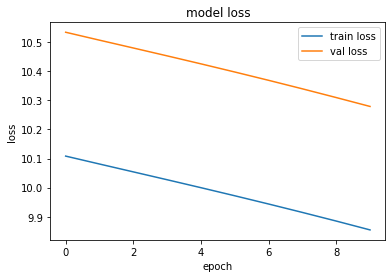


Predictive model running for column  0  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 42ms/step - loss: 13.2062 - last_time_step_mae: 0.3952 - val_loss: 12.6601 - val_last_time_step_mae: 0.3800
Epoch 2/10
9/9 [==============================] - 0s 9ms/step - loss: 13.1906 - last_time_step_mae: 0.3693 - val_loss: 12.6451 - val_last_time_step_mae: 0.3542
Epoch 3/10
9/9 [==============================] - 0s 9ms/step - loss: 13.1752 - last_time_step_mae: 0.3434 - val_loss: 12.6299 - val_last_time_step_mae: 0.3282
Epoch 4/10
9/9 [==============================] - 0s 8ms/step - loss: 13.1594 - last_time_step_mae: 0.3174 - val_loss: 12.6146 - val_last_time_step_mae: 0.3021
Epoch 5/10
9/9 [==============================] - 0s 8ms/step - loss: 13.1438 - last_time_step_mae: 0.2911 - val_loss: 12.5990 - val_last_time_step_mae: 0.2756
Epoch 6/10
9/9 [==============================] - 0s 8ms/step - loss: 13.1278 - last_time_step_mae: 0.2646 - val_loss: 12.5832 - val_l

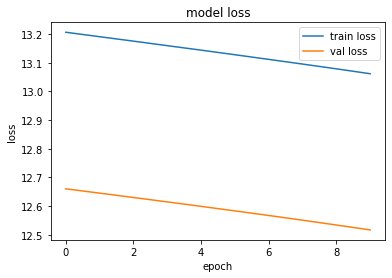


Predictive model running for column  1  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 41ms/step - loss: 9.2186 - last_time_step_mae: 0.1104 - val_loss: 8.9139 - val_last_time_step_mae: 0.0954
Epoch 2/10
9/9 [==============================] - 0s 9ms/step - loss: 9.2054 - last_time_step_mae: 0.0847 - val_loss: 8.9001 - val_last_time_step_mae: 0.0696
Epoch 3/10
9/9 [==============================] - 0s 9ms/step - loss: 9.1919 - last_time_step_mae: 0.0588 - val_loss: 8.8861 - val_last_time_step_mae: 0.0436
Epoch 4/10
9/9 [==============================] - 0s 8ms/step - loss: 9.1783 - last_time_step_mae: 0.0328 - val_loss: 8.8719 - val_last_time_step_mae: 0.0174
Epoch 5/10
9/9 [==============================] - 0s 9ms/step - loss: 9.1657 - last_time_step_mae: 0.0076 - val_loss: 8.8661 - val_last_time_step_mae: 0.0037
Epoch 6/10
9/9 [==============================] - 0s 8ms/step - loss: 9.1624 - last_time_step_mae: 0.0026 - val_loss: 8.8628 - val_last_time_ste

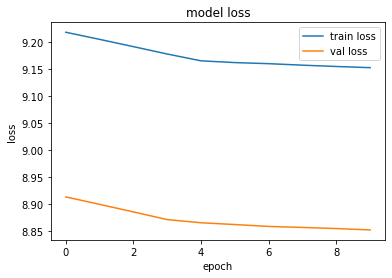


Predictive model running for column  2  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 40ms/step - loss: 32.1178 - last_time_step_mae: 0.6938 - val_loss: 34.5235 - val_last_time_step_mae: 0.6806
Epoch 2/10
9/9 [==============================] - 0s 9ms/step - loss: 32.1045 - last_time_step_mae: 0.6712 - val_loss: 34.5107 - val_last_time_step_mae: 0.6580
Epoch 3/10
9/9 [==============================] - 0s 8ms/step - loss: 32.0911 - last_time_step_mae: 0.6487 - val_loss: 34.4977 - val_last_time_step_mae: 0.6355
Epoch 4/10
9/9 [==============================] - 0s 8ms/step - loss: 32.0778 - last_time_step_mae: 0.6261 - val_loss: 34.4843 - val_last_time_step_mae: 0.6129
Epoch 5/10
9/9 [==============================] - 0s 9ms/step - loss: 32.0645 - last_time_step_mae: 0.6035 - val_loss: 34.4708 - val_last_time_step_mae: 0.5902
Epoch 6/10
9/9 [==============================] - 0s 9ms/step - loss: 32.0515 - last_time_step_mae: 0.5806 - val_loss: 34.4576 - val_l

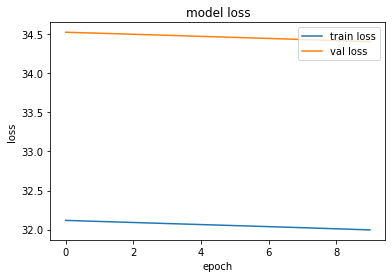


Predictive model running for column  3  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 40ms/step - loss: 3.5765 - last_time_step_mae: 0.3815 - val_loss: 3.1836 - val_last_time_step_mae: 0.3678
Epoch 2/10
9/9 [==============================] - 0s 9ms/step - loss: 3.5539 - last_time_step_mae: 0.3581 - val_loss: 3.1610 - val_last_time_step_mae: 0.3444
Epoch 3/10
9/9 [==============================] - 0s 8ms/step - loss: 3.5313 - last_time_step_mae: 0.3347 - val_loss: 3.1383 - val_last_time_step_mae: 0.3210
Epoch 4/10
9/9 [==============================] - 0s 8ms/step - loss: 3.5087 - last_time_step_mae: 0.3113 - val_loss: 3.1157 - val_last_time_step_mae: 0.2975
Epoch 5/10
9/9 [==============================] - 0s 9ms/step - loss: 3.4861 - last_time_step_mae: 0.2878 - val_loss: 3.0930 - val_last_time_step_mae: 0.2740
Epoch 6/10
9/9 [==============================] - 0s 9ms/step - loss: 3.4634 - last_time_step_mae: 0.2642 - val_loss: 3.0702 - val_last_time_ste

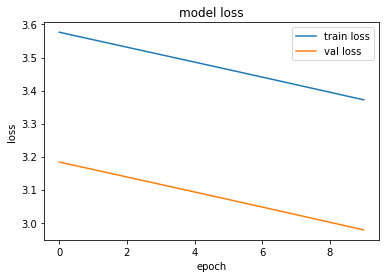


Predictive model running for column  4  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 42ms/step - loss: 10.4063 - last_time_step_mae: 0.9552 - val_loss: 9.6772 - val_last_time_step_mae: 0.9394
Epoch 2/10
9/9 [==============================] - 0s 8ms/step - loss: 10.3925 - last_time_step_mae: 0.9283 - val_loss: 9.6623 - val_last_time_step_mae: 0.9124
Epoch 3/10
9/9 [==============================] - 0s 9ms/step - loss: 10.3788 - last_time_step_mae: 0.9011 - val_loss: 9.6471 - val_last_time_step_mae: 0.8851
Epoch 4/10
9/9 [==============================] - 0s 9ms/step - loss: 10.3649 - last_time_step_mae: 0.8737 - val_loss: 9.6317 - val_last_time_step_mae: 0.8575
Epoch 5/10
9/9 [==============================] - 0s 8ms/step - loss: 10.3505 - last_time_step_mae: 0.8462 - val_loss: 9.6163 - val_last_time_step_mae: 0.8299
Epoch 6/10
9/9 [==============================] - 0s 9ms/step - loss: 10.3361 - last_time_step_mae: 0.8183 - val_loss: 9.6005 - val_last_ti

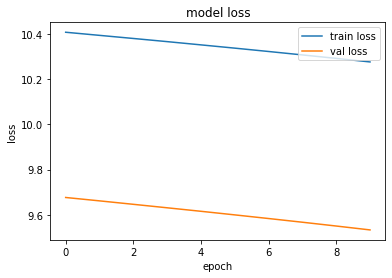

In [16]:
train_ori_set, test_ori_set = train_test_split(ori_set, train_size=0.5)
TRTR_results, TRTR_histories = predictive_train_test(train_ori_set, test_ori_set, epochs=10)

train_gen_set, test_gen_set = train_test_split(gen_set, train_size=0.5)
TSTS_results, TSTS_histories = predictive_train_test(train_gen_set, test_gen_set, epochs=10)

In [17]:
TRTR_results

,y_col,window_length,batch_size,epochs,test_loss,test_metric
0,0,130,64,10,11.959504,0.618504
1,1,130,64,10,7.361098,0.031741
2,2,130,64,10,33.622868,1.108977
3,3,130,64,10,3.458504,0.011816
4,4,130,64,10,10.398624,0.193545


In [18]:
TSTS_results

,y_col,window_length,batch_size,epochs,test_loss,test_metric
0,0,130,64,10,12.336844,0.137801
1,1,130,64,10,8.318829,0.000190
2,2,130,64,10,31.754053,0.470504
3,3,130,64,10,2.815384,0.154514
4,4,130,64,10,10.107716,0.685178


### Comparing TRTR vs TSTS results

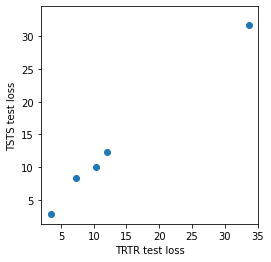

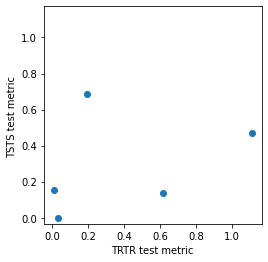

In [28]:
plt.scatter(TRTR_results['test_loss'], TSTS_results['test_loss'])
plt.xlabel('TRTR test loss')
plt.ylabel('TSTS test loss')
plt.axis('square')
plt.show()

plt.scatter(TRTR_results['test_metric'], TSTS_results['test_metric'])
plt.xlabel('TRTR test metric')
plt.ylabel('TSTS test metric ')
plt.axis('square')
plt.show()

### SRA